### LAB 3

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.integrate import solve_ivp
from scipy.integrate import quad
from scipy.optimize import curve_fit
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"

**Part 1**

In [9]:
#Data
data = np.loadtxt('atlas_z_to_ll.csv', delimiter=',', skiprows=1)
pT1, pT2, eta1, eta2, phi1, phi2, E1, E2 = data.T

In [10]:
#Momentum Components
px1 = pT1 * np.cos(phi1)
py1 = pT1 * np.sin(phi1)
pz1 = pT1 * np.sinh(eta1)
px2 = pT2 * np.cos(phi2)
py2 = pT2 * np.sin(phi2)
pz2 = pT2 * np.sinh(eta2)

#Other components
mz0 = 91.1880  #Mass of Z Boson  Gev/c^2

In [11]:
#Sum
E_tot = E1 + E2
px_tot = px1 + px2
py_tot = py1 + py2
pz_tot = pz1 + pz2

#Mass for each event
mass = np.sqrt(E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))

In [23]:
#Histogram (hist defined in part 2)
bins = np.linspace(80, 100, 41)
counts, edges = np.histogram(mass, bins = bins)
centers = 0.5 * (edges[:-1] + edges[1:])
errors = np.sqrt(counts)

<bound method Figure.tight_layout of <Figure size 800x600 with 1 Axes>>

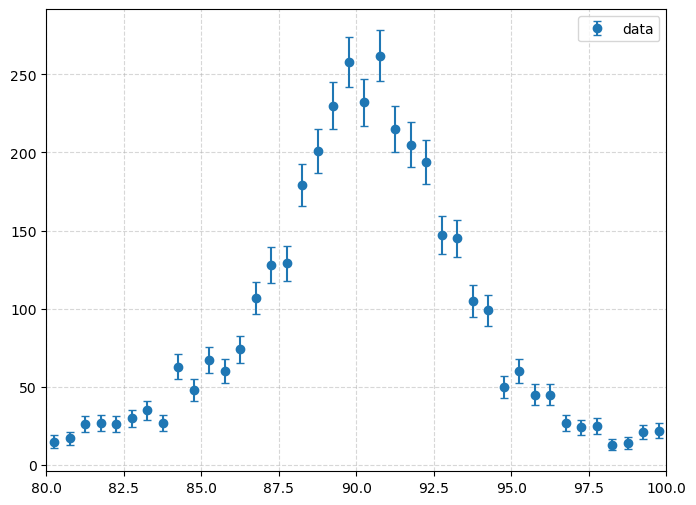

In [13]:
#Plot
fig, ax = plt.subplots(figsize = (8, 6))
ax.errorbar(centers, counts, yerr = errors, fmt = 'o', label = 'data', capsize = 3)
ax.set_xlim(80, 100)
ax.grid(True, linestyle = '--', alpha = 0.5)
ax.legend()
fig.tight_layout

**Part 2**

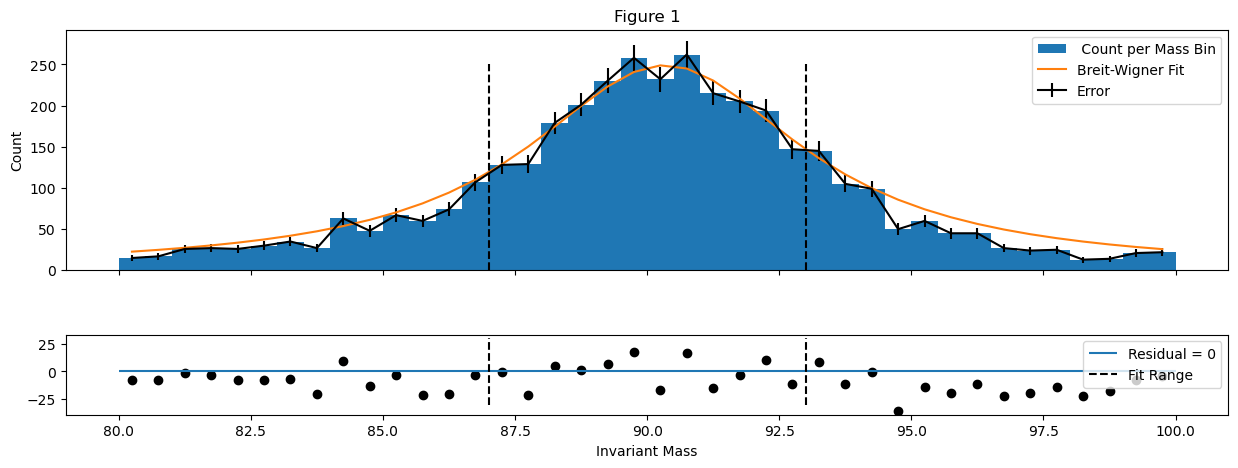

In [42]:
def D(m, m0, gamma):
    return 2500 * ((1/np.pi) * (gamma/2)/((m - m0)**2 + (gamma/2)**2))

err = np.sqrt(hist[0])
mask = (centers > 87) & (centers < 93)

bins_fit = centers[mask]
hist_fit = hist[0][mask]
err_fit = err[mask]

params, covar = curve_fit(D, bins_fit, hist_fit, sigma = err_fit, absolute_sigma = True)

#Plot
fig, (ax, ax_box) = plt.subplots(2, 1, sharex = True, figsize = (15, 5), gridspec_kw = {'height_ratios':[3, 1], 'hspace': 0.4}) 
hist = ax.hist(mass, bins = bins, label = ' Count per Mass Bin')
bin_centers = (bins[:-1] + bins[1:]) / 2
ax.errorbar(bin_centers, hist[0], np.sqrt(hist[0]), fmt = 'k', label = 'Error')
ax.plot(bin_centers, data_fit, label = "Breit-Wigner Fit")
ax.set_ylabel("Count")
ax.set_title("Figure 1")
ax.legend()

#Residual
residual = data_real - data_fit
ax_box.plot(bin_centers, residual, 'ok')
ax_box.hlines(0, 80, 100, label = "Residual = 0")
ax_box.vlines((87, 93), -30, 30, linestyle = '--', color = 'k', label = "Fit Range")
ax.vlines((87, 93), 0, 250, linestyle = '--', color = 'k', label = "Fit Range")
ax_box.set_xlabel("Invariant Mass")
ax_box.legend()

In [48]:
chisq = np.sum(((hist_fit - data_fit_mask)/err_fit)**2)
dof = len(hist_fit) - 2
red_chisq = chisq/dof
p_val = st.chi2.sf(chisq, dof)
uncertainty = np.sqrt(np.diag(covar))

ax.text(80, 150, f'mo = {params[0]:.1f} +/- {uncertainty[0]:.1f}\nChi-Square = {chisq:.1f} (Red.X^2[{dof:.1f}d.f.] ={red_chisq:.1f})\np-value = {p_val:.1f}');

**Part 3**

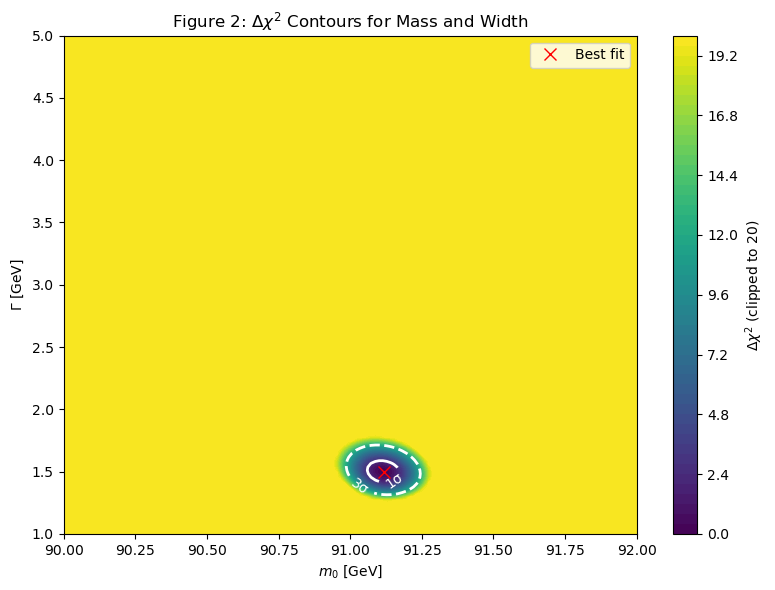

In [53]:
#Toy Invariant Mass Dataset
np.random.seed(0)
m0_true = 91.2
gamma_true = 2.5
N_events = 5000

mass_samples = m0_true + (gamma_true / 2) * np.random.standard_cauchy(size=N_events)
mass = mass_samples[(mass_samples > 80) & (mass_samples < 100)]

#Histogram again
bins = np.linspace(80, 100, 41)
counts, edges = np.histogram(mass, bins=bins)
centers = 0.5 * (edges[:-1] + edges[1:])
errors = np.sqrt(counts)

bin_width = edges[1] - edges[0]
norm_factor = len(mass) / 2 * bin_width

def breit_wigner(m, m0, gamma):
    return (1 / np.pi) * (gamma / 2) / ((m - m0)**2 + (gamma / 2)**2)

mask = (centers > 87) & (centers < 93)
popt, _ = curve_fit(lambda m, m0, gamma: norm_factor * breit_wigner(m, m0, gamma), centers[mask], counts[mask], p0=[m0_true, gamma_true], sigma=errors[mask],absolute_sigma=True)
m0_fit, gamma_fit = popt
chi2_min = np.sum(((counts[mask] - norm_factor * breit_wigner(centers[mask], *popt))**2) / errors[mask]**2)

#2D grid for Δχ²
m_vals = np.linspace(90, 92, 150)
g_vals = np.linspace(1, 5, 150)
M, G = np.meshgrid(m_vals, g_vals)
chi2_grid = np.zeros_like(M)

for i in range(G.shape[0]):
    for j in range(M.shape[1]):
        model = norm_factor * breit_wigner(centers[mask], M[i, j], G[i, j])
        chi2_grid[i, j] = np.sum(((counts[mask] - model)**2) / errors[mask]**2)

dchi2 = chi2_grid - chi2_min

#Plot
fig, ax = plt.subplots(figsize=(8, 6))
cont = ax.contourf(M, G, np.clip(dchi2, 0, 20), levels=50)
cbar = fig.colorbar(cont, ax=ax)
cbar.set_label(r'$\Delta\chi^2$ (clipped to 20)')

levels = [2.30, 11.83]
cs = ax.contour(M, G, dchi2, levels=levels, colors='white', linestyles=['-', '--'], linewidths=2)
ax.clabel(cs, fmt={2.30: '1σ', 11.83: '3σ'}, inline=True)
ax.plot(m0_fit, gamma_fit, 'rx', markersize=8, label='Best fit')
ax.set_xlabel(r'$m_0$ [GeV]')
ax.set_ylabel(r'$\Gamma$ [GeV]')
ax.set_title(r'Figure 2: $\Delta\chi^2$ Contours for Mass and Width')
ax.legend()
fig.tight_layout()